In [1]:
import json
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import re
import importlib
from utils import rustworx_graph

# Data Load

In [2]:
# GitHub
with open("../../github_graph.csv") as f:
    github = pd.read_csv(f)

# RPGF3
with open("../../rpgf3_accepted_applicants.json") as f:
    rpgf3 = json.load(f)

with open("../../../../../notebooks/data/RPGF3/RPGF3_tagged_projects.csv") as f:
    rpgf3_tagged_projects = pd.read_csv(f)

# get rid of Unnamed: 0 column
github = github.drop("Unnamed: 0", axis=1).dropna(subset=["user"]).drop_duplicates()
print(github.shape, github.columns)

rpgf3_df = pd.DataFrame(rpgf3)
print(rpgf3_df.shape, rpgf3_df.columns)

# get rid of Unnamed: 0 column
print(rpgf3_tagged_projects.shape, rpgf3_tagged_projects.columns)

(174252, 6) Index(['project', 'repo', 'type', 'user', 'month', 'total_amount'], dtype='object')
(644, 16) Index(['Project ID', 'Project Name', 'Applicant Type', 'Bio', 'Website',
       'Date', 'Attester Address', 'Payout Address', 'Link', 'Tags',
       'Contribution Description', 'Contributions: Github',
       'Contributions: Contracts', 'Contributions: Other',
       'Impact Description', 'Impact Metrics'],
      dtype='object')
(644, 50) Index(['Project ID', 'Project Name', 'Applicant Type', 'Website', 'Bio',
       'Payout Address', 'OSO Slug', 'Category: Collective Governance',
       'Category: Developer Ecosystem',
       'Category: End User Experience and Adoption', 'Category: OP Stack',
       'Funding: Governance Fund', 'Funding: Other', 'Funding: Partner Fund',
       'Funding: RPGF1', 'Funding: RPGF2', 'Funding: Revenue',
       'Keywords: Base', 'Keywords: Farcaster', 'Keywords: Zora',
       'Link: Contract on Base', 'Link: Contract on OP Mainnet', 'Link: Dune',
       

# Explore

## RPGF3 Applicants

In [3]:
print("Total RPGF3 applicants:", len(rpgf3_df["Project ID"].unique()))
interesting_columns = [
    "Project Name",
    "contribution_count",
    "github_contributions",
    "contract_contributions",
    "Tags",
]

Total RPGF3 applicants: 644


RPGF3 Projects by the different kinds of contributions to the ecosystem (GitHub, Contracts, etc.)

In [4]:
rpgf3_df["all_contributions"] = (
    rpgf3_df["Contributions: Contracts"]
    + rpgf3_df["Contributions: Github"]
    + rpgf3_df["Contributions: Other"]
)

# Make it a set, to remove duplicates
rpgf3_df["all_contributions"] = rpgf3_df["all_contributions"].apply(
    lambda x: list(set(x))
)

# what are the projects with the most raw count of contributions?
rpgf3_df["contribution_count"] = rpgf3_df["all_contributions"].apply(lambda x: len(x))
rpgf3_df["github_contributions"] = rpgf3_df["Contributions: Github"].apply(
    lambda x: len(x)
)
rpgf3_df["contract_contributions"] = rpgf3_df["Contributions: Contracts"].apply(
    lambda x: len(x)
)
rpgf3_df[interesting_columns].sort_values(
    by="contribution_count", ascending=False
).head(10)

,Project Name,contribution_count,github_contributions,contract_contributions,Tags
440,Bankless Publishing,77,0,32,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
340,Nacion Bankless,62,0,7,"[COLLECTIVE_GOVERNANCE, END_USER_EXPERIENCE_AN..."
608,IntoTheBlock Optimism Analytics,43,0,0,[END_USER_EXPERIENCE_AND_ADOPTION]
99,Invest in Music,31,0,0,[END_USER_EXPERIENCE_AND_ADOPTION]
91,ZEFIRIUM,30,0,0,[END_USER_EXPERIENCE_AND_ADOPTION]
232,Covalent,26,1,0,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
187,zerokn0wledge,23,0,0,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
86,The Rollup,21,0,0,[END_USER_EXPERIENCE_AND_ADOPTION]
75,libp2p,20,7,0,[OP_STACK]
478,GreenPill Network,20,0,0,[END_USER_EXPERIENCE_AND_ADOPTION]


In [5]:
rpgf3_github = rpgf3_df[rpgf3_df["github_contributions"] > 0]
print(
    "Total RPGF3 applicants with GitHub contributions:",
    len(rpgf3_github["Project ID"].unique()),
)
rpgf3_github[interesting_columns].sort_values(
    "contribution_count", ascending=False
).head(10)

Total RPGF3 applicants with GitHub contributions: 310


,Project Name,contribution_count,github_contributions,contract_contributions,Tags
232,Covalent,26,1,0,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
75,libp2p,20,7,0,[OP_STACK]
176,Holonym,20,6,11,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
168,Zengo: Decentralized Budget,18,3,8,[END_USER_EXPERIENCE_AND_ADOPTION]
528,Kromatika Finance,16,3,9,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
14,JEFE TOKEN,16,1,1,"[DEVELOPER_ECOSYSTEM, END_USER_EXPERIENCE_AND_..."
137,Test in Prod,16,5,0,[OP_STACK]
479,DecentrAgora,15,1,8,[END_USER_EXPERIENCE_AND_ADOPTION]
283,Fractal Visions,14,2,3,"[COLLECTIVE_GOVERNANCE, END_USER_EXPERIENCE_AN..."
159,The Red Guild,14,2,0,[DEVELOPER_ECOSYSTEM]


Filtered on the above, since these are the ones we can map to the GitHub dataset...i.e., they have a GitHub Repo.

What about the tags?

In [6]:
unique_tags = set([tag for tags in rpgf3_df["Tags"].values for tag in tags])
print("Unique tags:", len(unique_tags))
print("Unique tags:", unique_tags)

rpgf3_github_tags = rpgf3_github.explode("Tags")
tag_count = (
    rpgf3_github_tags.groupby("Tags")
    .count()["Project ID"]
    .reset_index()
    .rename(columns={"Project ID": "count"})
    .sort_values("count", ascending=False)
)
tag_count.head()

Unique tags: 4
Unique tags: {'END_USER_EXPERIENCE_AND_ADOPTION', 'COLLECTIVE_GOVERNANCE', 'OP_STACK', 'DEVELOPER_ECOSYSTEM'}


,Tags,count
1,DEVELOPER_ECOSYSTEM,202
2,END_USER_EXPERIENCE_AND_ADOPTION,185
3,OP_STACK,103
0,COLLECTIVE_GOVERNANCE,38


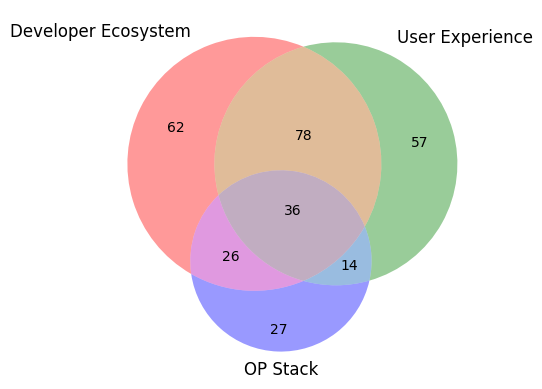

In [56]:
developer_ecosystem = set(
    rpgf3_github_tags[rpgf3_github_tags["Tags"] == "DEVELOPER_ECOSYSTEM"][
        "Project Name"
    ].values
)
ux = set(
    rpgf3_github_tags[rpgf3_github_tags["Tags"] == "END_USER_EXPERIENCE_AND_ADOPTION"][
        "Project Name"
    ].values
)
op_stack = set(
    rpgf3_github_tags[rpgf3_github_tags["Tags"] == "OP_STACK"]["Project Name"].values
)

venn3(
    [developer_ecosystem, ux, op_stack],
    set_labels=("Developer Ecosystem", "User Experience", "OP Stack"),
)

Most of the projects seems to be about the developer ecosystem, and user experience.  There are a few projects about the OP stack itself.

## Github Contributions 

In [57]:
additional_columns = ["Contributions: Github"]
rpgf3_projects = rpgf3_github[interesting_columns + additional_columns]
rpgf3_projects.rename(
    columns={"Project Name": "name", "Tags": "tags", "Contributions: Github": "repos"},
    inplace=True,
)
rpgf3_projects.head()

# re-key this to be at the repo level
rpgf3_projects_repos = rpgf3_projects.explode("repos")

# clean up the repo


def grab_org_repo(repo_string):
    pattern = r".+github\.com/([^/]+)(/[^/]+)?"
    # pattern = r"github.com/([^/]+)/([^/]+)"
    match = re.match(pattern, repo_string)

    if match is None:
        print(f"Could not match {repo_string}")
        return None

    org, repo = match.group(1, 2)

    if repo is None:
        return ""

    return f"{org}{repo}"


# rpgf3_projects_repos["repo"] = rpgf3_projects_repos["repos"].str.extract(pattern)[0] + "/" + rpgf3_projects_repos["repos"].str.extract(pattern)[1]
rpgf3_projects_repos["repo"] = rpgf3_projects_repos["repos"].apply(
    lambda x: grab_org_repo(x)
)
print(rpgf3_projects_repos.repo.unique().shape)
print(rpgf3_projects_repos.columns)
rpgf3_projects_final = (
    rpgf3_projects_repos.dropna(subset=["repo"])[["name", "tags", "repo"]]
    # drop anything where repo == ""
    .query("repo != ''")
)
print(rpgf3_projects_final.shape)
rpgf3_projects_final.head()

(424,)
Index(['name', 'contribution_count', 'github_contributions',
       'contract_contributions', 'tags', 'repos', 'repo'],
      dtype='object')
(473, 3)


/var/folders/jh/9_qy7nd96v9_q0_x1sffyq9c0000gn/T/ipykernel_1151/1753524704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rpgf3_projects.rename(


,name,tags,repo
0,sunce86,[DEVELOPER_ECOSYSTEM],openethereum/openethereum
0,sunce86,[DEVELOPER_ECOSYSTEM],tomusdrw/rust-web3
0,sunce86,[DEVELOPER_ECOSYSTEM],cowprotocol/services
0,sunce86,[DEVELOPER_ECOSYSTEM],ethereum/go-ethereum
2,Public Assembly,[DEVELOPER_ECOSYSTEM],public-assembly/assembly-press


So, we have 473 projects from RPGF3 with a GitHub Repo, that we can look at the contribution data for. We probably won't be able to match everything, but let's first see what we have in GitHub.

The model for GitHub is:

- Project provides Repos
- Users contribute to Repos
    - Contributions can be Commit, PR, Issue 
    - Contributions are tied to a time period 
    - Contributions are aggregated by User, Repo, Time Period, and Type

In [58]:
print(f"Total users: {github.user.unique().shape[0]}")
print(f"Total repos: {github.repo.unique().shape[0]}")
print(f"Total contributions: {github.total_amount.sum()}")

github.head()

Total users: 25840
Total repos: 4258
Total contributions: 987527.0


,project,repo,type,user,month,total_amount
0,abi-to-sol-gnidan,gnidan/abi-to-sol,PR,42241.0,2021-11,1.0
1,abi-to-sol-gnidan,gnidan/abi-to-sol,Commit,42241.0,2021-11,12.0
2,across,across-protocol/frontend-v1,PR,49602.0,2021-11,4.0
3,across,across-protocol/frontend-v1,PR,89557.0,2021-11,6.0
4,across,across-protocol/frontend-v2,Commit,40690.0,2021-11,1.0


### Each repo has about 22 commits, 4 Issues, and 10 PRs across all time and all its users

In [59]:
github_repo_contributions = (
    github.groupby(["repo", "type"]).agg({"total_amount": "sum"}).reset_index()
)
github_repo_contributions.groupby(["type"]).agg(
    {"total_amount": "median"}
).reset_index().head()

,type,total_amount
0,Commit,22.0
1,Issue,4.5
2,PR,10.0


### Each user makes about 2 commits, 1 Issue, and 2 PRs, and mostly to 1 repository

In [60]:
github_user_contributions = (
    github.groupby(["user", "type"])
    .agg({"total_amount": "sum", "repo": "nunique"})
    .reset_index()
)
# github_user_contributions.sort_values("repo", ascending=False).head()
github_user_contributions.groupby(["type"]).agg(
    {"total_amount": "median", "repo": "median"}
).reset_index().head()

,type,total_amount,repo
0,Commit,2.0,1.0
1,Issue,1.0,1.0
2,PR,2.0,1.0


### The distribution of contributors and contributions

In [12]:
github_repos = (
    github.groupby(["repo"])
    .agg(
        total_contributors=("user", "nunique"),
        total_contributions=("total_amount", "sum"),
    )
    .round(1)
    .reset_index()
)
print(f"Median contributors per repo: {github_repos.total_contributors.median()}")

github_repos.sort_values("total_contributors", ascending=False).head(10)

Median contributors per repo: 3.0


,repo,total_contributors,total_contributions
766,defillama/defillama-adapters,2342,25283.0
973,ethereum/ethereum-org-website,1669,24763.0
990,ethereum/go-ethereum,1478,9108.0
1246,foundry-rs/foundry,1229,8508.0
216,blockscout/blockscout,1086,7378.0
2989,nomicfoundation/hardhat,966,6312.0
1120,ethers-io/ethers.js,875,1772.0
4048,wagmi-dev/wagmi,733,2644.0
2342,ledgerwatch/erigon,729,10591.0
947,ethereum/eips,600,10420.0


So, there are some repos with an insane number of contributors and contributions. We can focus on this distribution of contributions. I suspect it is power law distributed - a few projects will have a ton of contributions, with the vast majority making up a long tail.

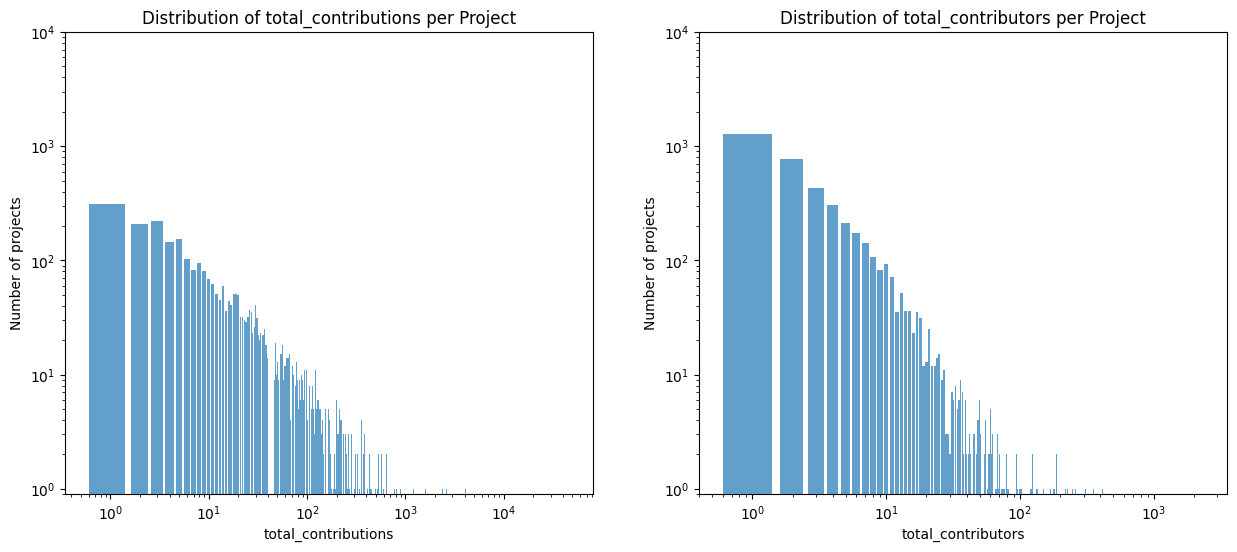

In [61]:
fields = ["total_contributions", "total_contributors"]

github_repos.sort_values("total_contributions", ascending=False).head(10)

# make a 2 column, 1 row fig, ax
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Make both of them have the same scale on the y axis

for i, field in enumerate(fields):
    grouped_data = github_repos.groupby(field).size().reset_index(name="count")
    grouped_data = grouped_data.sort_values(by=field)
    ax[i].bar(
        grouped_data[field], grouped_data["count"], width=0.8, alpha=0.7, label=field
    )
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlabel(field)
    ax[i].set_ylabel("Number of projects")
    ax[i].set_ylim(0.9, 1e4)
    ax[i].set_title(f"Distribution of {field} per Project")

plt.show()

I always find the above diagram confusing, so let's look at the same data in a different way, a _percentile_ way.  One key take back from it is that its steeply descending, which suggests a strong power law distribution, especially on the total contributors.

So, the vast majority of projects have about 10 contributors total. Once you get to beyond that number of contributors, you're entering the top 1% of projects by the number of contributors. You can make this conclusion because the scale of the above graphs are loglog => linear descending slope means exponential decay.

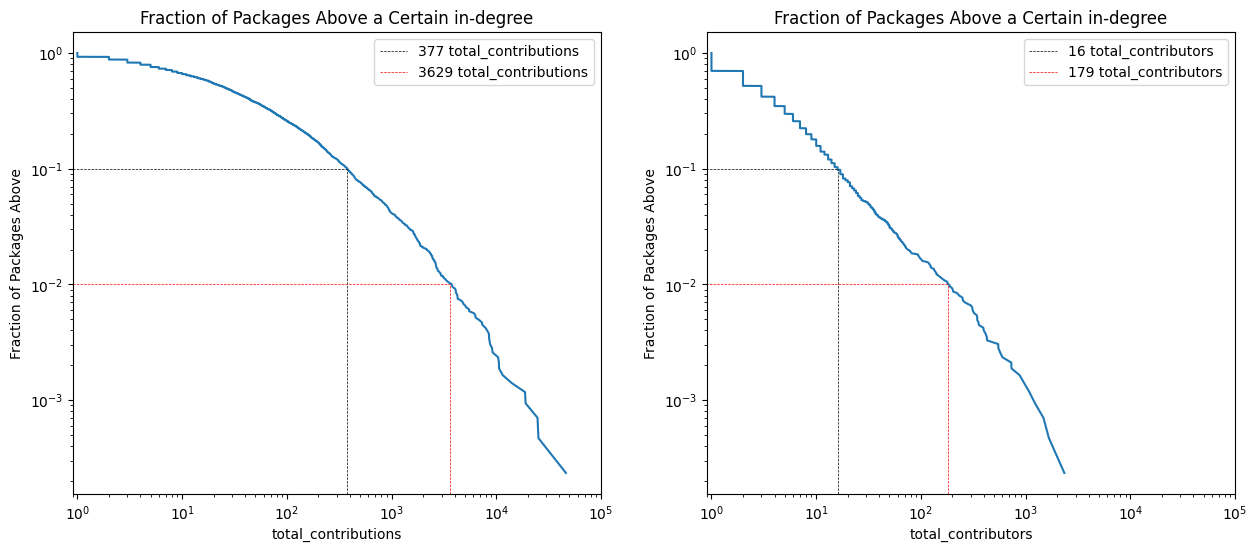

In [62]:
fields = ["total_contributions", "total_contributors"]

# make a 2 column, 1 row fig, ax
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Make both of them have the same scale on the y axis

for i, field in enumerate(fields):
    sorted_data = github_repos.sort_values(field, ascending=True)
    total_repos = len(sorted_data)
    field_values = sorted_data[field]
    fraction_above = [(total_repos - i) / total_repos for i in range(total_repos)]
    ax[i].loglog(field_values, fraction_above)
    ax[i].set_xlabel(field)
    ax[i].set_ylabel("Fraction of Packages Above")
    ax[i].set_title("Fraction of Packages Above a Certain in-degree")
    ax[i].set_xlim(0.9, 1e5)
    ten_percent_value = sorted_data[field].quantile(0.9)
    one_percent_value = sorted_data[field].quantile(0.99)

    # 90th percentile
    ax[i].plot(
        [ten_percent_value, ten_percent_value],
        [0, 0.1],
        label=f"{int(ten_percent_value)} {field}",
        linestyle="--",
        color="black",
        linewidth=0.5,
    )
    ax[i].plot(
        [0, ten_percent_value], [0.1, 0.1], linestyle="--", color="black", linewidth=0.5
    )

    # 99th percentile
    ax[i].plot(
        [one_percent_value, one_percent_value],
        [0, 0.01],
        label=f"{int(one_percent_value)} {field}",
        linestyle="--",
        color="red",
        linewidth=0.5,
    )
    ax[i].plot(
        [0, one_percent_value], [0.01, 0.01], linestyle="--", color="red", linewidth=0.5
    )

    ax[i].legend()

plt.show()

The image above represents the power law in a different fashion. In a power law distribution, a few projects or entities have a disproportionately large number of contributions or contributors, while the majority of projects or entities have relatively fewer contributions or contributors. 

In this case, the x-axis represents the amount of contributions or unique contributors for each repository, while the y-axis represents the fraction of projects above the corresponding x value. The plot shows that as the amount of contributions or unique contributors increases, the fraction of projects above those many contributors decreases rapidly.

> _If you follow the black line on `total_contributions`, you can see that a repo that has 377 total contributions is in the top 10% of repos by number of contributions._

What this highlights the presence of highly influential or popular projects that attract a large number of contributors or generate a large number of contributions. 

The point of all this is that networks where pageRank is a good measure of value tend to be power law distributed as well.  There are a small collection of authoritative nodes in any one domain, and this rule of thumb is a pretty general one, applicable to webpages, open-source packages, media sources, Twitter power users, etc.

Before joining GitHub with the RPGF3 set, let's do the exact same breakdown above by users and their number of contributions.  If it looks the same, the conclusion would be that there would be a small number of users who are responsible for an enormous number of contributions across these packages. 

In [63]:
github_users = (
    github.groupby(["user"])
    .agg(
        unique_repos=("repo", "nunique"),
        total_contributions=("total_amount", "sum"),
    )
    .round(1)
    .reset_index()
)
github_users.sort_values("unique_repos", ascending=False).head(10)

,user,unique_repos,total_contributions
2807,40283.0,718,20376.0
2335,38365.0,419,8506.0
21532,4864911.0,335,1050.0
2678,39604.0,244,3551.0
1243,35760.0,192,577.0
2817,40374.0,186,5517.0
22148,5741549.0,167,297.0
0,33251.0,155,7704.0
2810,40324.0,151,2558.0
22067,5730201.0,121,286.0


There's a user who has contributed to 718 repositories...that's a lot.  And there is also a precipitous dropoff in the number of users who have contributed to more than 100 repositories, within the top 10.  So, it looks like the same power law distribution.

Total Users:  25840


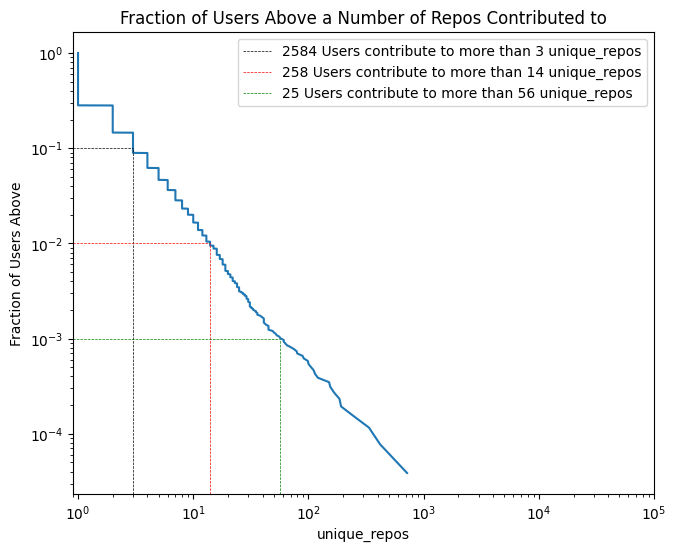

In [64]:
field = "unique_repos"
fig = plt.figure(figsize=(7.5, 6))

sorted_data = github_users.sort_values(field, ascending=True)
total_users = len(sorted_data)
field_values = sorted_data[field]
fraction_above = [(total_users - i) / total_users for i in range(total_users)]
plt.loglog(field_values, fraction_above)
plt.xlabel(field)
plt.ylabel("Fraction of Users Above")
plt.title("Fraction of Users Above a Number of Repos Contributed to")
plt.xlim(0.9, 1e5)
ten_percent_value = sorted_data[field].quantile(0.9)
one_percent_value = sorted_data[field].quantile(0.99)

print("Total Users: ", total_users)

# 90th percentile
plt.plot(
    [ten_percent_value, ten_percent_value],
    [0, 0.1],
    label=f"{int(0.1 * total_users)} Users contribute to more than {int(ten_percent_value)} {field}",
    linestyle="--",
    color="black",
    linewidth=0.5,
)
plt.plot(
    [0, ten_percent_value], [0.1, 0.1], linestyle="--", color="black", linewidth=0.5
)

# 99th percentile
plt.plot(
    [one_percent_value, one_percent_value],
    [0, 0.01],
    label=f"{int(0.01 * total_users)} Users contribute to more than {int(one_percent_value)} {field}",
    linestyle="--",
    color="red",
    linewidth=0.5,
)
plt.plot(
    [0, one_percent_value], [0.01, 0.01], linestyle="--", color="red", linewidth=0.5
)

# 99.9th percentile
one_per_mille_value = sorted_data[field].quantile(0.999)
plt.plot(
    [one_per_mille_value, one_per_mille_value],
    [0, 0.001],
    label=f"{int(0.001 * total_users)} Users contribute to more than {int(one_per_mille_value)} {field}",
    linestyle="--",
    color="green",
    linewidth=0.5,
)
plt.plot(
    [0, one_per_mille_value],
    [0.001, 0.001],
    linestyle="--",
    color="green",
    linewidth=0.5,
)

plt.legend()

plt.show()

And there we have it. Who are these 25 power users who have contributed to more than 56 repositories, keeping in mind that there 4258 repositories in this dataset? Our guess should be that when we run pageRank on this particular graph, these users will be the most important ones.

Let's join the projects back, now that we have a better understanding of the projects and the users.

# Join

In [65]:
# Use tagged projects, that have an OSO Slug
print(rpgf3_tagged_projects.shape[0])

rpgf3_slugs = rpgf3_tagged_projects[~rpgf3_tagged_projects["OSO Slug"].isna()]
print(rpgf3_slugs.shape[0])

df = rpgf3_slugs.merge(github, left_on="OSO Slug", right_on="project", how="left")
print(df.shape)

# how many in test_df are NaN?
print(df[df["project"].isna()].shape)

# how many in test_df are not NaN?
print(df[~df["project"].isna()].shape)

# drop the NA
df = df[~df["project"].isna()]
print(df.shape)
print(df.columns)

644
313
(174259, 56)
(7, 56)
(174252, 56)
(174252, 56)
Index(['Project ID', 'Project Name', 'Applicant Type', 'Website', 'Bio',
       'Payout Address', 'OSO Slug', 'Category: Collective Governance',
       'Category: Developer Ecosystem',
       'Category: End User Experience and Adoption', 'Category: OP Stack',
       'Funding: Governance Fund', 'Funding: Other', 'Funding: Partner Fund',
       'Funding: RPGF1', 'Funding: RPGF2', 'Funding: Revenue',
       'Keywords: Base', 'Keywords: Farcaster', 'Keywords: Zora',
       'Link: Contract on Base', 'Link: Contract on OP Mainnet', 'Link: Dune',
       'Link: Flipside', 'Link: GitHub', 'Link: GitHub (duneanalytics)',
       'Link: GitHub (ethereum)', 'Link: GitHub (ethereum-optimism)',
       'Link: NPM Package', 'Link: Optimism Gov', 'Link: Substack',
       'Link: Twitter', '# GitHub Repos', 'Date First Commit', 'Total Stars',
       'Total Forks', 'Total Contributors', 'Contributors Last 6 Months',
       'Avg Monthly Active Devs Last

# Graph

The model is:

- User contributes to Repo
    - Contribution is of a certain type (Commit, PR, Issue)
    - Contribution is in a certain month
    - Contribution has a certain amount of contributions

Or, in cypher terms:

```cypher
MATCH (u:User)-[con:CONTRIBUTED_TO]->(r:Repo)
RETURN con.type, con.month, con.total_amount
```

and;

- Projects provide repos

```cypher
MATCH (p:Project)-[pr:PROVIDES]->(r:Repo)
```

In [66]:
importlib.reload(rustworx_graph)

# Nodes
users = df[["user"]].drop_duplicates()
print(users.shape)
repos = github[["repo"]].drop_duplicates()
print(repos.shape)
projects = df.drop(
    ["user", "repo", "total_amount", "type", "month", "OSO Slug"], axis=1
).drop_duplicates()
print(projects.shape)

G = rustworx_graph.RawGraph()
G.load_nodes(users, "user")
G.load_nodes(repos, "repo")
G.add_projects(projects)
G.update_node_indices()

print()
print(f"Added {len(G.index_map)} nodes")
print()

# Edges
contributes = github[
    ["user", "repo", "total_amount", "type", "month"]
].drop_duplicates()
print(contributes.shape)
provides = df[["project", "repo"]].drop_duplicates()
print(provides.shape)

G.add_user_contributions(contributes)
G.add_project_provides(provides)
G.update_edge_indices()

(25840, 1)
(4258, 1)
(306, 50)

Added 30404 nodes

(166175, 5)
(4265, 2)


This makes it _slightly_ easier to to navigate the graph. We can start with a project, find how many repos it provides, list them, and then count all the contributions to each of those repos from our set.

In [83]:
project = "openzeppelin"

print(G[G.index_map[project]])  # index that rustworkx uses to track the node
print(f"{project} provides {G.out_degree(G.index_map[project])} repos")

print()

for repo in G.neighbors(G.index_map[project]):
    print(f"{G.in_degree(repo):5} users contributed to {G[repo].id:50s}")

openzeppelin @ 30286
openzeppelin provides 58 repos

    9 users contributed to openzeppelin/token-vouching                       
    5 users contributed to openzeppelin/compound-governance-proposal-behavior
   17 users contributed to openzeppelin/contract-bots-gang                   
   33 users contributed to openzeppelin/workshops                            
    2 users contributed to openzeppelin/safe-contracts-context               
  173 users contributed to openzeppelin/contracts-wizard                     
   26 users contributed to openzeppelin/openzeppelin-test-helpers            
   26 users contributed to openzeppelin/defender-as-code                     
    4 users contributed to openzeppelin/proposal143                          
    2 users contributed to openzeppelin/sample-crosschain-env                
    6 users contributed to openzeppelin/proxy-explorer                       
  191 users contributed to openzeppelin/nile                                 
    3 users

Zooming on a specific repo, say `openzeppelin/merkle-tree`, we can do a similar sort of analysis

In [122]:
repo = "openzeppelin/merkle-tree"

print(G[G.index_map[repo]])  # index that rustworkx uses to track the node
print(f"{repo} was supported by {G.in_degree(G.index_map[repo])} users")

print()

# Repo won't have neighbors, since it's a DAG, and users contributes to repos
for source, target, edge in G.in_edges(G.index_map[repo]):
    if G[source].metadata["label"] == "user":
        print(
            f"{G[source].id:9.1f} submitted {int(edge.metadata['total_amount']):3} {edge.metadata['type']:6s}"
        )

openzeppelin/merkle-tree @ 28424
openzeppelin/merkle-tree was supported by 36 users

 463654.0 submitted   1 Issue 
  46183.0 submitted   1 Issue 
 176949.0 submitted   1 Issue 
  54859.0 submitted   1 Issue 
  34570.0 submitted   1 Commit
  34173.0 submitted   1 Commit
  34173.0 submitted   1 PR    
  38008.0 submitted   1 Issue 
  34570.0 submitted   3 Commit
  34570.0 submitted   1 PR    
 230208.0 submitted   1 PR    
 327829.0 submitted   1 Issue 
  43357.0 submitted   1 Issue 
  38467.0 submitted   1 Commit
  38467.0 submitted   1 PR    
 452803.0 submitted   1 Issue 
  36954.0 submitted   2 Commit
  34570.0 submitted   5 Commit
  36954.0 submitted   2 PR    
 452815.0 submitted   1 Issue 
 373296.0 submitted   1 Issue 
  40907.0 submitted   2 Issue 
  34755.0 submitted   1 Issue 
  34570.0 submitted   5 Commit
  34570.0 submitted   1 PR    
  34570.0 submitted   1 Commit
 265345.0 submitted   1 Issue 
 102800.0 submitted   1 Issue 
  90499.0 submitted   1 Issue 
  42168.0 submit

And finally, pick a user, say `34570.0`, and let's see what they've contributed to

In [136]:
user = 34570

print(G[G.index_map[user]])  # index that rustworkx uses to track the node

print(f"{user}'s contributed to {G.out_degree(G.index_map[user])} repos")
print()

for repo in G.neighbors(G.index_map[user]):
    repo_project = [
        source
        for source, target, edge in G.in_edges(repo)
        if G[source].metadata["label"] == "project"
    ][0]
    print(
        f"contributed to {G[repo_project].metadata['Project Name']:35s} {G[repo].id:50s}"
    )

34570.0 @ 6499
34570's contributed to 323 repos

contributed to TypeChain / DethCode                dethcrypto/typechain                              
contributed to OpenZeppelin Contracts              openzeppelin/chai-bn                              
contributed to Solidity                            ethereum/solidity                                 
contributed to Slither                             crytic/slither                                    
contributed to OpenZeppelin Contracts              openzeppelin/openzeppelin-test-helpers            
contributed to OpenZeppelin Contracts              openzeppelin/defender-docs                        
contributed to OpenZeppelin Contracts              openzeppelin/solidity-ast                         
contributed to The Ethernaut                       openzeppelin/ethernaut                            
contributed to OpenZeppelin Contracts              openzeppelin/governor-quorum-bot                  
contributed to OpenZeppelin Contr